# Continuous stirred tank reactor (CSTR)

In this Jupyter Notebook we illustrate the example **CSTR**.

**Open an interactive online Jupyter Notebook with this content on Binder:**

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/do-mpc/do-mpc.git/master?filepath=%2Fdocumentation%2Fsource%2Fexample_gallery%2FCSTR.ipynb)

The example consists of the three modules **template_model.py**, which describes the system model, **template_mpc.py**, which defines the settings for the control and **template_simulator.py**, which sets the parameters for the simulator.
The modules are used in **main.py** for the closed-loop execution of the controller.
The file **post_processing.py** is used for the visualization of the closed-loop control run.
One exemplary result will be presented at the end of this tutorial as a gif.

In the following the different parts are presented. But first, we start by importing basic modules and **do-mpc**.

In [1]:
!pip install do-mpc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!apt install imagemagick

Reading package lists... Done
Building dependency tree       
Reading state information... Done
imagemagick is already the newest version (8:6.9.7.4+dfsg-16ubuntu6.13).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [3]:
import numpy as np
import sys
from casadi import *

# Add do_mpc to path. This is not necessary if it was installed via pip
sys.path.append('../../../')

# Import do_mpc package:
import do_mpc

import matplotlib.pyplot as plt

## Model

In the following we will present the configuration, setup and connection between these blocks, starting with the `model`.
The considered model of the CSTR is continuous and has 4 states and 2 control inputs.
The model is initiated by:

In [4]:
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

### States and control inputs

The four states are concentration of reactant A ($C_{\text{A}}$), the concentration of reactant B ($C_{\text{B}}$), the temperature inside the reactor ($T_{\text{R}}$) and the temperature of the cooling jacket ($T_{\text{K}}$):

In [5]:
# States struct (optimization variables):
C_a = model.set_variable(var_type='_x', var_name='C_a', shape=(1,1))
C_b = model.set_variable(var_type='_x', var_name='C_b', shape=(1,1))
T_R = model.set_variable(var_type='_x', var_name='T_R', shape=(1,1))
T_K = model.set_variable(var_type='_x', var_name='T_K', shape=(1,1))

# State measurements
C_b_meas = model.set_meas('C_b_1_meas', C_b, meas_noise=True)
T_R_meas = model.set_meas('T_R_1_meas', T_R, meas_noise=True)

The control inputs are the feed $F$ and the heat flow $\dot{Q}$:

In [6]:
# Input struct (optimization variables):
F = model.set_variable(var_type='_u', var_name='F')
Q_dot = model.set_variable(var_type='_u', var_name='Q_dot')

# Input measurements
F_meas = model.set_meas('F_meas', F, meas_noise=False)
Q_dot_meas = model.set_meas('Q_dot', Q_dot, meas_noise=False)

### ODE and parameters

The system model is described by the ordinary differential equation:

\begin{align}
\dot{C}_{\text{A}} &= F \cdot \alpha \cdot (C_{\text{A},0} - C_{\text{A}}) - k_1 \cdot C_{\text{A}} - k_3 \cdot C_{\text{A}}^2, \\
\dot{C}_{\text{B}} &= F \cdot C_{\text{B}} + k_1 \cdot C_{\text{A}} - k_2 \cdot C_{\text{B}}, \\
\dot{T}_{\text{R}} &= \frac{k_1 \cdot C_{\text{A}} \cdot H_{\text{R},ab} + k_2 \cdot C_{\text{B}} \cdot  H_{\text{R},bc} + k_3 \cdot C_{\text{A}}^2 \cdot H_{\text{R},ad}} {-\rho \cdot \beta \cdot c_p}\\
&+ F \cdot (T_{\text{in}} - T_{\text{R}}) + \frac{K_w \cdot A_{\text{R}} \cdot(T_{\text{K}}-T_{\text{R}})}{\rho \cdot \beta \cdot c_p \cdot V_{\text{R}}}, \\
\dot{T}_{\text{K}} &= \frac{\dot{Q} + k_w \cdot A_{\text{R}} \cdot T_{\text{dif}}}{m_k \cdot C_{p,k}},
\end{align}

where

\begin{align}
k_1 &= \gamma \cdot k_{0,\text{ab}} \cdot \exp\left(\frac{-E_{\text{A},\text{ab}}}{T_{\text{R}}+273.15}\right), \\
k_1 &= k_{0,\text{bc}} \cdot \exp \left( \frac{-E_{\text{A},\text{bc}}}{T_{\text{R}}+273.15} \right), \\
k_3 &= k_{0,\text{ad}} \cdot \exp \left( \frac{-E_{\text{A},\text{ad}}}{T_{\text{R}}+273.15} \right).
\end{align}

The 
parameters $\alpha$ and $\beta$ and $\gamma$ are uncertain while the rest of the parameters is considered certain:

In [7]:
# Certain parameters
K0_ab = 1.287e12 # K0 [h^-1]
K0_bc = 1.287e12 # K0 [h^-1]
K0_ad = 9.043e9 # K0 [l/mol.h]
R_gas = 8.3144621e-3 # Universal gas constant
E_A_ab = 9758.3*1.00 #* R_gas# [kj/mol]
E_A_bc = 9758.3*1.00 #* R_gas# [kj/mol]
E_A_ad = 8560.0*1.0 #* R_gas# [kj/mol]
H_R_ab = 4.2 # [kj/mol A]
H_R_bc = -11.0 # [kj/mol B] Exothermic
H_R_ad = -41.85 # [kj/mol A] Exothermic
Rou = 0.9342 # Density [kg/l]
Cp = 3.01 # Specific Heat capacity [kj/Kg.K]
Cp_k = 2.0 # Coolant heat capacity [kj/kg.k]
A_R = 0.215 # Area of reactor wall [m^2]
V_R = 10.0 # Volume of reactor [l]
m_k = 5.0 # Coolant mass[kg]
T_in = 135.0 # Temp of inflow [Celsius]
K_w = 4032.0 # [kj/h.m^2.K]
C_A0 = 5.1 # Concentration of A in input  [mol/l]
CBMAX = 1.13

# Uncertain parameters:
alpha = model.set_variable(var_type='parameter', var_name='alpha')
beta = model.set_variable(var_type='parameter', var_name='beta')
gamma = model.set_variable(var_type='parameter', var_name='gamma')

In the next step, we formulate the $k_i$-s:

In [8]:
# Auxiliary terms
K_1 = gamma * K0_ab * exp((-E_A_ab)/((T_R+273.15)))
K_2 =  K0_bc * exp((-E_A_bc)/((T_R+273.15)))
K_3 = K0_ad * exp((-E_A_ad)/((T_R+273.15)))

Additionally, we define an artificial variable of interest, that is not a state of the system, but will be later used for plotting:

In [9]:
T_dif = model.set_expression(expr_name='T_dif', expr=T_R-T_K)

WIth the help ot the $k_i$-s and $T_{\text{dif}}$ we can define the ODEs:

In [10]:
model.set_rhs('C_a', F*(alpha*C_A0 - C_a) -K_1*C_a - K_3*(C_a**2), process_noise = False)
model.set_rhs('C_b', -F*C_b + K_1*C_a - K_2*C_b)
model.set_rhs('T_R', ((K_1*C_a*H_R_ab + K_2*C_b*H_R_bc + K_3*(C_a**2)*H_R_ad)/(-Rou*beta*Cp)) + F*(T_in-T_R) + (((K_w*A_R)*(-T_dif))/(Rou*beta*Cp*V_R)))
model.set_rhs('T_K', (Q_dot + K_w*A_R*(T_dif))/(m_k*Cp_k))

Finally, the model setup is completed:

In [11]:
# Build the model
model.setup()

## Controller


Next, the model predictive controller is configured.
First, one member of the mpc class is generated with the prediction model defined above:

In [12]:
mpc = do_mpc.controller.MPC(model)

We choose the prediction horizon `n_horizon`, set the robust horizon `n_robust` to 1. The time step `t_step` is set to one second and parameters of the applied discretization scheme orthogonal collocation are as seen below:

In [13]:
setup_mpc = {
    'n_horizon': 20,
    'n_robust': 1,
    'open_loop': 0,
    't_step': 0.005,
    'state_discretization': 'collocation',
    'collocation_type': 'radau',
    'collocation_deg': 2,
    'collocation_ni': 2,
    'store_full_solution': True,
    # Use MA27 linear solver in ipopt for faster calculations:
    #'nlpsol_opts': {'ipopt.linear_solver': 'MA27'}
}

mpc.set_param(**setup_mpc)

Because the magnitude of the states and inputs is very different, we introduce scaling factors:

In [14]:
mpc.scaling['_x', 'T_R'] = 100
mpc.scaling['_x', 'T_K'] = 100
mpc.scaling['_u', 'Q_dot'] = 2000
mpc.scaling['_u', 'F'] = 100

### Objective

The goal of the CSTR is to obtain a mixture with a concentration of $C_{\text{B,ref}} = 0.6$ mol/l, and $T = 135$ °C.
Additionally, we add a penalty on input changes for both control inputs, to obtain a smooth control performance.

In [15]:
_x = model.x
mterm = (_x['C_b'] - 0.6)**2 # terminal cost # set-point tracking
lterm = (_x['T_R'] - 135)**2 # stage cost # set-point tracking

mpc.set_objective(mterm=mterm, lterm=lterm)

mpc.set_rterm(F=0.1, Q_dot = 1e-3) # input penalty # Scaling for quad. cost.

### Constraints

In the next step, the constraints of the control problem are set.
In this case, there are only upper and lower bounds for each state and the input:

In [16]:
# lower bounds of the states
mpc.bounds['lower', '_x', 'C_a'] = 0.1
mpc.bounds['lower', '_x', 'C_b'] = 0.1
mpc.bounds['lower', '_x', 'T_R'] = 50
mpc.bounds['lower', '_x', 'T_K'] = 50

# upper bounds of the states
mpc.bounds['upper', '_x', 'C_a'] = 2
mpc.bounds['upper', '_x', 'C_b'] = 2
mpc.bounds['upper', '_x', 'T_K'] = 140

# lower bounds of the inputs
mpc.bounds['lower', '_u', 'F'] = 5
mpc.bounds['lower', '_u', 'Q_dot'] = -8500

# upper bounds of the inputs
mpc.bounds['upper', '_u', 'F'] = 100
mpc.bounds['upper', '_u', 'Q_dot'] = 0.0

If a constraint is not critical, it is possible to implement it as a **soft** constraint.
This means, that a small violation of the constraint does not render the optimization infeasible.
Instead, a penalty term is added to the objective.
**Soft** constraints can always be applied, if small violations can be accepted and it might even be necessary to apply MPC in a safe way (by avoiding avoiding numerical instabilities).
In this case, we define the upper bounds of the reactor temperature as a **soft** constraint by using `mpc.set_nl_cons()`.

In [17]:
mpc.set_nl_cons('T_R', _x['T_R'], ub=140, soft_constraint=True, penalty_term_cons=1e2)

SX(T_R)

### Uncertain values

The explicit values of the two uncertain parameters $\alpha$, $\beta$ and $\gamma$, which are considered in the scenario tree, are given by:

In [18]:
alpha_var = np.array([1., 1.05, 0.95])
beta_var = np.array([1., 1.1, 0.9])
gamma_var = np.array([1., 1.2, 0.8])

mpc.set_uncertainty_values(alpha = alpha_var, beta = beta_var, gamma = gamma_var)

This means with `n_robust=1`, that 9 different scenarios are considered.
The setup of the MPC controller is concluded by:

In [19]:
mpc.setup()

## Estimator

MHE

## Configuring the moving horizon estimator
The first step of configuring the moving horizon estimator is to call the class with a list of all parameters to be estimated. An empty list (default value) means that no parameters are estimated.
The list of estimated parameters must be a subset (or all) of the previously defined parameters.

<div class="alert alert-info">
**Note** 
    
WE CAN DEFINE MORE UNCERTAIN PARAMETERS (BEYOND $\alpha , \beta , \gamma$) THAT WE DON'T ESTIMATE

In many cases we will use the same model for (robust) control and MHE estimation. In that case it is possible to have some external parameters (e.g. weather prediction) that are uncertain but cannot be estimated. 
</div>

In [20]:
mhe = do_mpc.estimator.MHE(model, ['alpha', 'beta', 'gamma'])

### MHE parameters:
Next, we pass MHE parameters. Most importantly, we need to set the time step and the horizon.
We also choose to obtain the measurement from the MHE data object. 
Alternatively, we are able to set a user defined measurement function that is called at each timestep and returns the `N` previous measurements for the estimation step.

In [21]:
setup_mhe = {
    't_step': 0.1,
    'n_horizon': 10,
    'store_full_solution': True,
    'meas_from_data': True
}
mhe.set_param(**setup_mhe)

### Objective function
The most important step of the configuration is to define the objective function for the MHE problem:

\begin{align}
\underset{
    \begin{array}{c}
    \mathbf{x}_{0:N+1}, \mathbf{u}_{0:N}, p,\\
    \mathbf{w}_{0:N}, \mathbf{v}_{0:N}
    \end{array}
    }{\mathrm{min}}
    &\frac{1}{2}\|x_0-\tilde{x}_0\|_{P_x}^2+\frac{1}{2}\|p-\tilde{p}\|_{P_p}^2
    +\sum_{k=0}^{N-1} \left(\frac{1}{2}\|v_k\|_{P_{v,k}}^2
    + \frac{1}{2}\|w_k\|_{P_{w,k}}^2\right),\\
    &\left.\begin{aligned}
    \mathrm{s.t.}\quad
    x_{k+1} &= f(x_k,u_k,z_k,p,p_{\text{tv},k})+ w_k,\\
    y_k &= h(x_k,u_k,z_k,p,p_{\text{tv},k}) + v_k, \\
    &g(x_k,u_k,z_k,p_k,p_{\text{tv},k}) \leq 0
    \end{aligned}\right\} k=0,\dots, N
\end{align}

We typically consider the formulation shown above, where the user has to pass the weighting matrices ``P_x``, ``P_v``, ``P_p`` and ``P_w``.
In our concrete example, we assume a perfect model without process noise and thus ``P_w`` is not required. 

We set the objective function with the weighting matrices shown below:

In [22]:
P_v = np.diag(np.array([1, 1])) #2 states measured with (meas_noise=True)
P_x = np.eye(4) # 4 states
P_p = 6*np.eye(3) #6 inputs: 4 states + 2 control

mhe.set_default_objective(P_x, P_v, P_p)

In [23]:
mhe.scaling['_x', 'T_R'] = 100
mhe.scaling['_x', 'T_K'] = 100
mhe.scaling['_u', 'Q_dot'] = 2000
mhe.scaling['_u', 'F'] = 100

### Bounds
The MHE implementation also supports bounds for states, inputs, parameters which can be set as shown below.
For the given example, it is especially important to set realistic bounds on the estimated parameter. Otherwise the MHE solution is a poor fit.

In [24]:
# lower bounds of the states
mhe.bounds['lower', '_x', 'C_a'] = 0.1
mhe.bounds['lower', '_x', 'C_b'] = 0.1
mhe.bounds['lower', '_x', 'T_R'] = 50
mhe.bounds['lower', '_x', 'T_K'] = 50

# upper bounds of the states
mhe.bounds['upper', '_x', 'C_a'] = 2
mhe.bounds['upper', '_x', 'C_b'] = 2
mhe.bounds['upper', '_x', 'T_K'] = 140

# lower bounds of the inputs
mhe.bounds['lower', '_u', 'F'] = 5
mhe.bounds['lower', '_u', 'Q_dot'] = -8500

# upper bounds of the inputs
mhe.bounds['upper', '_u', 'F'] = 100
mhe.bounds['upper', '_u', 'Q_dot'] = 0.0

### Realizations of uncertain parameters

For the simulatiom, it is necessary to define the numerical realizations of the uncertain parameters in `p_num` and the time-varying parameters in `tvp_num`.
First, we get the structure of the uncertain and time-varying parameters:

In [25]:
# p_num_mhe = mhe.get_p_template()
# tvp_num = mhe.get_tvp_template()

We define two functions which are called in each simulation step, which return the current realizations of the parameters, with respect to defined inputs (in this case `t_now`):

In [26]:
# function for time-varying parameters
# def tvp_fun(t_now):
#     return tvp_num


# def p_fun_mhe(t_now):
#     # uncertain parameters
#     p_num_mhe['alpha'] = 1
#     p_num_mhe['beta'] = 1
#     p_num_mhe['gamma'] = 1
#     return p_num_mhe

These two custum functions are used in the simulation via:

In [27]:
# simulator.set_tvp_fun(tvp_fun)
# mhe.set_p_fun(p_fun_mhe)

### Setup
Similar to the controller, simulator and model, we finalize the MHE configuration by calling:

In [28]:
mhe.setup()

## Simulator

To create a simulator in order to run the MPC in a closed-loop, we create an instance of the **do-mpc** simulator which is based on the same model:

In [29]:
simulator = do_mpc.simulator.Simulator(model)

For the simulation, we use the same time step `t_step` as for the optimizer:

In [30]:
params_simulator = {
    'integration_tool': 'cvodes',
    'abstol': 1e-10,
    'reltol': 1e-10,
    't_step': 0.1
}

simulator.set_param(**params_simulator)

### Parameters
In the `model` we have defined the inertia of the masses as parameters. The `simulator` is now parametrized to simulate using the "true" values at each timestep. In the most general case, these values can change, which is why we need to supply a function that can be evaluted at each time to obtain the current values. 
**do-mpc** requires this function to have a specific return structure which we obtain first by calling:

In [31]:
p_template_sim = simulator.get_p_template()

We need to define a function which returns this structure with the desired numerical values. For our simple case:

In [32]:
def p_fun_sim(t_now):
    p_template_sim['alpha'] = 1
    p_template_sim['beta'] = 1
    p_template_sim['gamma'] = 1
    return p_template_sim

This function is now supplied to the `simulator` in the following way:

In [33]:
simulator.set_p_fun(p_fun_sim)

In [34]:
simulator.setup()

## Closed-loop simulation

For the simulation of the MPC configured for the CSTR, we inspect the file **main.py**.
We define the initial state of the system and set it for all parts of the closed-loop configuration:

In [35]:
# Set the initial state of mpc, simulator and estimator:
C_a_0 = 0.8 # This is the initial concentration inside the tank [mol/l]
C_b_0 = 0.5 # This is the controlled variable [mol/l]
T_R_0 = 134.14 #[C]
T_K_0 = 130.0 #[C]

x0 = np.array([C_a_0, C_b_0, T_R_0, T_K_0]).reshape(-1,1)

mpc.x0 = x0
simulator.x0 = x0
mhe.x0 = x0

mhe.p_est0 = np.array([1, 1, 1])

# Set the initial input of mpc, simulator and estimator:
F_0 = 10 # This is the initial inlet flow rate [l/h]
Q_dot_0 = -1 # This is the heat removed [kW]

u0 = np.array([F_0, Q_dot_0]).reshape(-1,1)

mpc.u0 = u0
simulator.u0 = u0
mhe.u0 = u0


mpc.set_initial_guess()

mhe.set_initial_guess()

Now, we simulate the closed-loop for 50 steps (and suppress the output of the cell with the magic command `%%capture`):

In [36]:
%%capture
for k in range(50):
    u0 = mpc.make_step(x0)
    v0 = 0.1*np.random.randn(model.n_v,1) # measurement noise
    y_next = simulator.make_step(u0, v0=v0)
    x0 = mhe.make_step(y_next)

## Animating the results

To animate the results, we first configure the **do-mpc** graphics object, which is initiated with the respective data object:

In [37]:
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)

We quickly configure Matplotlib.

In [38]:
from matplotlib import rcParams
rcParams['axes.grid'] = True
rcParams['font.size'] = 18

We then create a figure, configure which lines to plot on which axis and add labels.

In [45]:
%%capture
fig, ax = plt.subplots(6, sharex=True, figsize=(16,12))
# Configure plot:
mpc_graphics.add_line(var_type='_x', var_name='C_a', axis=ax[0], color='#FF00FF') # magenta
mpc_graphics.add_line(var_type='_x', var_name='C_b', axis=ax[1], color='#2ca02c') # green CONTROL
mpc_graphics.add_line(var_type='_x', var_name='T_R', axis=ax[2], color='#2ca02c') # green CONTROL
mpc_graphics.add_line(var_type='_x', var_name='T_K', axis=ax[2], color='#DC143C') # crimson
mpc_graphics.add_line(var_type='_aux', var_name='T_dif', axis=ax[3])
mpc_graphics.add_line(var_type='_u', var_name='F', axis=ax[4], color='#ff7f0e') # orange INPUT
mpc_graphics.add_line(var_type='_u', var_name='Q_dot', axis=ax[5], color='#ff7f0e') # orange INPUT
ax[0].set_ylabel('$C_{A}(mol/L)$')
ax[0].set_xlabel('time [h]')
ax[1].set_ylabel('$C_{B}(mol/L)$')
ax[1].set_xlabel('time [h]')
ax[2].set_ylabel('$T(°C)$')
ax[2].set_xlabel('time [h]')
ax[3].set_ylabel('$\Delta T [°C]$')
ax[3].set_xlabel('time [h]')
ax[4].set_ylabel('$F(L/h)$')
ax[4].set_xlabel('time [h]')
ax[5].set_ylabel('$\dot{Q}(kW)$')
ax[5].set_xlabel('time [h]')


Some "cosmetic" modifications are easily achieved with the structure ``pred_lines`` and ``result_lines``.

In [46]:
# Update properties for all prediction lines:
for line_i in mpc_graphics.pred_lines.full:
    line_i.set_linewidth(2)
# Highlight nominal case:
for line_i in np.sum(mpc_graphics.pred_lines['_x', :, :,0]):
    line_i.set_linewidth(5)
    line_i.set_color('#2ca02c') # green
for line_i in np.sum(mpc_graphics.pred_lines['_u', :, :,0]):
    line_i.set_linewidth(5)
    line_i.set_color('#ff7f0e') # orange
for line_i in np.sum(mpc_graphics.pred_lines['_aux', :, :,0]):
    line_i.set_linewidth(5)

# Add labels
label_lines = mpc_graphics.result_lines['_x', 'C_a']
ax[0].legend(label_lines, ['Reactor Concentration of A, $C_{A}$'])
label_lines = mpc_graphics.result_lines['_x', 'C_b']
ax[1].legend(label_lines, ['Reactor Concentration of B, $C_{B}$'])
label_lines = mpc_graphics.result_lines['_x', 'T_R']+mpc_graphics.result_lines['_x', 'T_K']
ax[2].legend(label_lines, ['Reactor Temperature, $T_{R}$', 'Jacket Temperature, $T_{K}$'])
label_lines = mpc_graphics.result_lines['_aux', 'T_dif']
ax[3].legend(label_lines, ['$T_{R}-T_{K}$'])
label_lines = mpc_graphics.result_lines['_u', 'F']
ax[4].legend(label_lines, ['Inlet Flow, $F$'])
label_lines = mpc_graphics.result_lines['_u', 'Q_dot']
ax[5].legend(label_lines, ['Heat Removed, $\dot{Q}$'])

# Make all predictions transparent:
for line_i in mpc_graphics.pred_lines.full: line_i.set_alpha(0.2)

fig.align_ylabels()

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


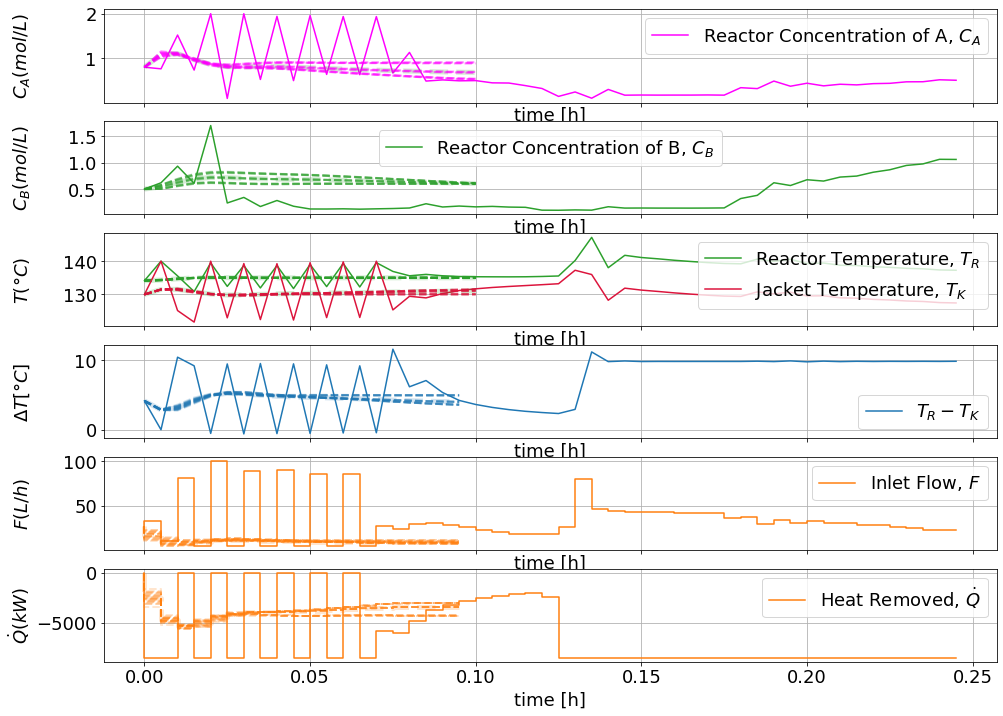

In [47]:
# Plot predictions from t=0
mpc_graphics.plot_predictions(t_ind=0)
# Plot results until current time
mpc_graphics.plot_results()
mpc_graphics.reset_axes()
fig

After importing the necessary package:

In [ ]:
from matplotlib.animation import FuncAnimation, ImageMagickWriter
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation

matplotlib.rc('animation', html='jshtml')

We obtain the animation with:

In [ ]:
def update(t_ind):
    print('Writing frame: {}.'.format(t_ind), end='\r')
    mpc_graphics.plot_results(t_ind=t_ind)
    mpc_graphics.plot_predictions(t_ind=t_ind)
    mpc_graphics.reset_axes()
    lines = mpc_graphics.result_lines.full
    return lines

n_steps = mpc.data['_time'].shape[0]


anim = FuncAnimation(fig, update, frames=n_steps, blit=True)

gif_writer = ImageMagickWriter(fps=5)
anim.save('anim_CSTR.gif', writer=gif_writer)

In [ ]:
anim

Recorded trajectories are shown as solid lines, whereas predictions are dashed. We highlight the nominal prediction with a thicker line.

In [ ]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
anim.save('anim_CSTR.mp4', writer=writer)